We will include the following preprocessing steps:

Lowercasing

Removing punctuation

Tokenization

Removing stopwords

Stemming (optional but useful)

In [101]:
import pandas as pd
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [102]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:
df = pd.read_csv("https://raw.githubusercontent.com/amankharwal/Website-data/master/spam.csv", encoding='latin-1')
df.columns = ['label', 'text']
df = df[['label', 'text']]


In [104]:
def preprocess(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # 3. Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 5. Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # 6. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 7. Tokenization
    tokens = text.split()
    
    # 8. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # 9. Remove short words
    tokens = [word for word in tokens if len(word) >= 3]
    
    # 10. Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    return ' '.join(tokens)

In [105]:
# Apply full preprocessing
df['cleaned'] = df['text'].apply(preprocess)

In [106]:
# Encode target variable
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

In [107]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned'])
y = df['label_num']

In [108]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=3)


In [109]:
X

<5572x6833 sparse matrix of type '<class 'numpy.float64'>'
	with 42132 stored elements in Compressed Sparse Row format>

In [110]:
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label_num, Length: 5572, dtype: int64

In [111]:
y_pred

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [122]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [124]:


# Model training
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [114]:
# Prediction
y_pred = model.predict(X_test)

In [115]:
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [116]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9623318385650225

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       0.99      0.73      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



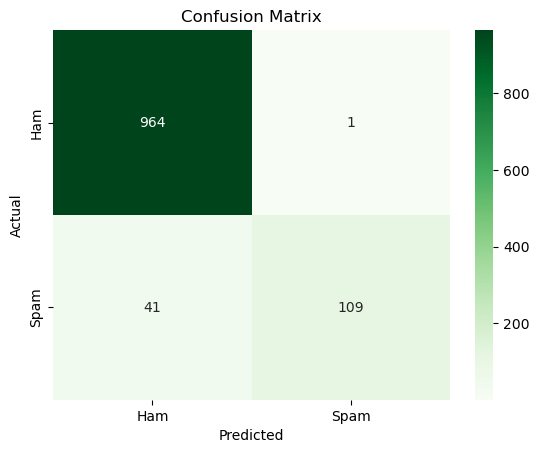

In [117]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Class Imbalance Fix (Ham >> Spam):

Use class weighting or upsample the spam class:

In [118]:
from sklearn.utils import resample
# Split into spam and ham
df_ham = df[df.label_num == 0]
df_spam = df[df.label_num == 1]

# Upsample spam to match ham count
from sklearn.utils import resample
df_spam_upsampled = resample(df_spam,
                             replace=True,
                             n_samples=len(df_ham),
                             random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_ham, df_spam_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [119]:
df_balanced

,label,text,cleaned,label_num
0,ham,Mm yes dear look how i am hugging you both. :-P,ye dear look hug,0
1,ham,But pls dont play in others life.,pl dont play other life,0
2,ham,i can call in &lt;#&gt; min if thats ok,call ltgt min that,0
3,ham,HMM yeah if your not too grooved out! And im l...,hmm yeah groov look forward pound special,0
4,spam,"Latest News! Police station toilet stolen, cop...",latest news polic station toilet stolen cop noth,1
...,...,...,...,...
9645,spam,"SMS SERVICES. for your inclusive text credits,...",sm servic inclus text credit pl goto login qxj...,1
9646,spam,"Loan for any purpose Ã¥Â£500 - Ã¥Â£75,000. Hom...",loan purpos ã¥â£ ã¥â£ homeown tenant welcom pr...,1
9647,spam,"If you don't, your prize will go to another cu...",dont prize anoth custom pmin polo ltd suit lon...,1
9648,ham,"Ya, told..she was asking wats matter?",toldsh ask wat matter,0


In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=3)
X = vectorizer.fit_transform(df_balanced['cleaned'])
y = df_balanced['label_num']


In [126]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')  # important!


In [127]:
# Use Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

Accuracy: 0.9927461139896373

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       975
           1       0.99      0.99      0.99       955

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



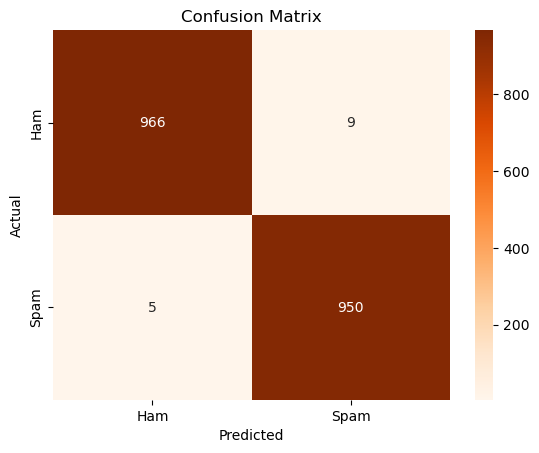

In [128]:
# Evaluate Performance
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            cmap='Oranges', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [129]:
def predict_spam(message):
    clean = preprocess(message)
    vec = vectorizer.transform([clean])
    pred = model.predict(vec)[0]
    return "Spam 🚫" if pred == 1 else "Ham ✅"

# 💬 Take input from user
user_message = input("Enter a message to check if it's Spam or Not: ")
result = predict_spam(user_message)
print(f"\nPrediction: {result}")


Enter a message to check if it's Spam or Not:  Congratulations! you won a free ticket.



Prediction: Spam 🚫


In [130]:
def predict_spam(message):
    clean = preprocess(message)
    vec = vectorizer.transform([clean])
    pred = model.predict(vec)[0]
    return "Spam 🚫" if pred == 1 else "Ham ✅"

# 🔁 Continuous loop until user types 'exit'
print("📩 Spam Detector\nType 'exit' to quit.\n")

while True:
    user_input = input("Enter a message: ")
    if user_input.lower() == 'exit':
        print("Goodbye! 👋")
        break
    result = predict_spam(user_input)
    print(f"Prediction: {result}\n")


📩 Spam Detector
Type 'exit' to quit.



Enter a message:  Congratulations! you won a free ticket.


Prediction: Spam 🚫



Enter a message:  exit


Goodbye! 👋


🔍 Accuracy: 0.9927461139896373

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       975
           1       0.99      0.99      0.99       955

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



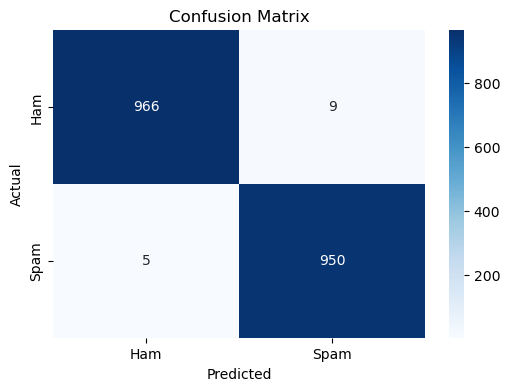

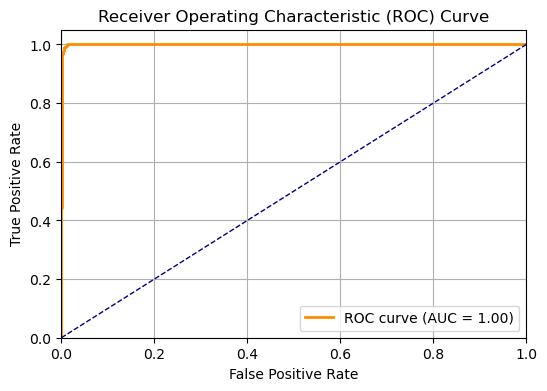

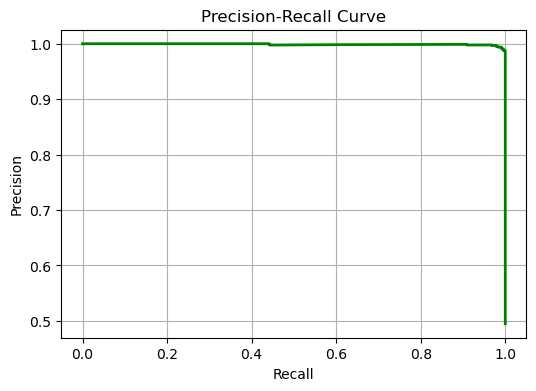

In [131]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc,
    precision_recall_curve
)
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Print classification report and accuracy
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# 2️⃣ Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 3️⃣ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 4️⃣ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()
